## Winnipeg Real Estate Pricing Analysis
### Introduction
In this project I have scraped data from various data about Winnipeg real estate price and its Boroughs.Then I used Foursquare API to get the common venues of the boroughs.Then using K-means clustering I clustered Winnipeg  Neighborhoods on the basis of the common venues.

### Importing Libraries

First of all we need to install all the libraries we need for the analysis.

In [79]:
!pip install beautifulsoup4
!pip install html5lib
!pip install lxml
!pip install requests
# Install opencage
!pip install opencage
!pip install geopy
!pip install geocoder
!pip install geopandas

In [80]:
import requests
import urllib.request
import csv
from bs4 import BeautifulSoup
import numpy as np # library to handle data in a vectorized manner
import csv
import re
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from pandas import json_normalize

import geocoder as geocoder

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from opencage.geocoder import OpenCageGeocode


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Data Manipulation
In order to make the results easier to read and interpret, I decided to join each postcode to the Neighborhood Name.

First of all I scraped the Geonames Table using Beautiful Soup 4

In [81]:
r = requests.get('https://www.geonames.org/postal-codes/CA/MB/manitoba.html').text
from bs4 import BeautifulSoup
soup = BeautifulSoup(r,'lxml')
#print(soup.prettify())

In [82]:
gdp = soup.find_all("table", attrs={"class": "restable"})
print("Number of tables on site: ",len(gdp))

Number of tables on site:  1


In [83]:
# Lets go ahead and scrape first table with HTML code gdp[0]
table1 = gdp[0]
# the head will form our column names
body = table1.find_all("tr")
# Head values (Column names) are the first items of the body list
head = body[0] # 0th item is the header row
body_rows = body[1:] # All other items becomes the rest of the rows

# Lets now iterate through the head HTML code and make list of clean headings

# Declare empty list to keep Columns names
headings = []
for item in head.find_all("th"): # loop through all th elements
    # convert the th elements to text and strip "\n"
    item = (item.text).rstrip("\n")
    # append the clean column name to headings
    headings.append(item)
print(headings)

['', 'Place', 'Code', 'Country', 'Admin1', 'Admin2', 'Admin3']


In [84]:
# Next is now to loop though the rest of the rows
all_rows = [] # will be a list for list for all rows
for row_num in range(len(body_rows)): # A row at a time
    row = [] # this will old entries for one row
    for row_item in body_rows[row_num].find_all("td"): #loop through all row entries
        aa = re.sub("(\xa0)|(\n)|,","",row_item.text)
        row.append(aa)
    all_rows.append(row)

In [85]:
df = pd.DataFrame(data=all_rows,columns=headings)
print(df.shape)
df.columns

(135, 7)


Index(['', 'Place', 'Code', 'Country', 'Admin1', 'Admin2', 'Admin3'], dtype='object')

In [86]:
df.columns = ['Num','Neighborhood','PostCode','Country','Admin1','Admin2','Admin3']
df = df[~df['Admin2'].isin(['Brandon','Headingley','Taché','South',''])]
df.drop(['Admin1', 'Country','Admin3','Num','Admin2'], axis='columns', inplace=True) # Delete the columns that I dont need
df = df.dropna(how='any',axis=0)
df.head()

,Neighborhood,PostCode
16,Winnipeg (Transcona),R2C
20,Winnipeg (River East North),R2G
22,Winnipeg (St. Boniface NW),R2H
24,Winnipeg (St. Boniface NE),R2J
26,Winnipeg (River East Central),R2K


### Cleaning the table

In [87]:
df['Neighborhood'] = df['Neighborhood'].str.replace('Winnipeg','')
df['Neighborhood'] =  df['Neighborhood'].apply(lambda x: x.replace('(','').replace(')','')) 
df['Neighborhood'] =  df['Neighborhood'].str.split('/').str[0]
df.head()

,Neighborhood,PostCode
16,Transcona,R2C
20,River East North,R2G
22,St. Boniface NW,R2H
24,St. Boniface NE,R2J
26,River East Central,R2K


## Getting property data of Winnipeg

First of all I scraped the www.point2homes.com Table using Beautiful Soup 4 and I saved the result as a CSV. To make this Jupyter Notebook shorter, I'll not include the code used to scrape the table but I'm going to open the CSV file as a DataFrame and work directly on it.

In [88]:
df2 = pd.read_csv("winnipeg price.csv")
df2.head()

,AvePrice,PostCode
0,283873,R2H
1,271628,R3M
2,283873,R2H
3,271628,R3L
4,257606,R2M


## Merge the table of Winnipeg Boroughs and Winnipeg House Prices


In [90]:
data=pd.merge(df, df2)
data.head()

,Neighborhood,PostCode,AvePrice
0,Transcona,R2C,232143
1,Transcona,R2C,384000
2,Transcona,R2C,379900
3,Transcona,R2C,264900
4,Transcona,R2C,279900


In [91]:
#df2['AvePrice'] = df2['AvePrice'].str.replace("$","")
df2['AvePrice'] = pd.to_numeric(df2['AvePrice']).astype(int)
df2.head()


,AvePrice,PostCode
0,283873,R2H
1,271628,R3M
2,283873,R2H
3,271628,R3L
4,257606,R2M


## Finding Longitude and Latitude of the Locations

In [92]:
def getLatLong(row):
    #print('post :{}'.format(row[:]))
    #print('neigh :{}'.format(row[1]))
    # initialize your variable to None
    lat_lng_coords = None
    search_query = '{}, Winnipeg,Canada'.format(row)
    # loop until you get the coordinates
    try:
        while(lat_lng_coords is None):
            #g = geocoder.here(search_query,app_id=app_id,app_code=app_code)
            g = geocoder.arcgis(search_query)
            lat_lng_coords = g.latlng
            #print('FIRST')
    except IndexError:
        latitude = 0.0
        longitude = 0.0
        print('BACKUP')
        return [latitude,longitude]

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    print(latitude, longitude)
    return [latitude, longitude]

In [93]:
coords_list = data['PostCode'].apply(getLatLong).tolist()

49.888180000000034 -96.99896999999999
49.888180000000034 -96.99896999999999
49.888180000000034 -96.99896999999999
49.888180000000034 -96.99896999999999
49.888180000000034 -96.99896999999999
49.888180000000034 -96.99896999999999
49.888180000000034 -96.99896999999999
49.888180000000034 -96.99896999999999
49.888180000000034 -96.99896999999999
49.888180000000034 -96.99896999999999
49.942180000000064 -97.05899999999997
49.88606000000004 -97.11884999999995
49.88606000000004 -97.11884999999995
49.88606000000004 -97.11884999999995
49.88606000000004 -97.11884999999995
49.88606000000004 -97.11884999999995
49.871440000000064 -97.06416999999999
49.871440000000064 -97.06416999999999
49.871440000000064 -97.06416999999999
49.871440000000064 -97.06416999999999
49.871440000000064 -97.06416999999999
49.871440000000064 -97.06416999999999
49.92240000000004 -97.08297999999996
49.92240000000004 -97.08297999999996
49.92240000000004 -97.08297999999996
49.92240000000004 -97.08297999999996
49.92240000000004 -97

## Merging the values in the dataframe

In [94]:
data[['Latitude','Longitude']]=pd.DataFrame(coords_list,columns=['Latitude', 'Longitude'])
data

,Neighborhood,PostCode,AvePrice,Latitude,Longitude
0,Transcona,R2C,232143,49.88818,-96.99897
1,Transcona,R2C,384000,49.88818,-96.99897
2,Transcona,R2C,379900,49.88818,-96.99897
3,Transcona,R2C,264900,49.88818,-96.99897
4,Transcona,R2C,279900,49.88818,-96.99897
5,Transcona,R2C,589900,49.88818,-96.99897
6,Transcona,R2C,549900,49.88818,-96.99897
7,Transcona,R2C,264900,49.88818,-96.99897
8,Transcona,R2C,279900,49.88818,-96.99897
9,Transcona,R2C,379900,49.88818,-96.99897


### Use geopy library to get the latitude and longitude values of Winnipeg.

In [95]:
address = 'Winnipeg'

locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Winnipeg are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Winnipeg are 49.8955367, -97.1384584.


## Create a map of Winnipeg with neighborhoods superimposed on top

In [96]:

map_winnipeg = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(data['Latitude'], 
                                  data['Longitude'], 
                                  data['Neighborhood'],):
    label = '{},'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_winnipeg)  
    
map_winnipeg




#### Next, utilizing the Foursquare API to explore the neighborhoods and segment them.

## Define Foursquare Credentials and Version

In [97]:
CLIENT_ID = 'GXF5LWSB1UUM4H5MZLYEQJMKBAVSSUIBMS424DXLCGKJKHZK' # your Foursquare ID
CLIENT_SECRET = '0X0GXNHTUPF0WTS53GFVCGFADJLYEOW5CKLKFPHZXNCGURZU' # your Foursquare Secret
VERSION = '20180604'

In [98]:
def getBuiltUrl(neigh_lat,neigh_long,radius=1400):
    # type your answer here
    LIMIT=100
    #radius=1000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_lat, 
    neigh_long, 
    radius, 
    LIMIT)
    return url

### Exploring first Location in our dataframe

In [99]:
neigh_name, neigh_post, neigh_price, neigh_lat, neigh_long = data.iloc[0]
print('Latitude and longitude values of {} are {}, {}.'.format(neigh_name, 
                                                               neigh_lat, 
                                                               neigh_long))
results = requests.get(getBuiltUrl(neigh_lat,neigh_long)).json()
results

Latitude and longitude values of  Transcona are 49.888180000000034, -96.99896999999999.


{'meta': {'code': 200, 'requestId': '5fca86936d31c0183b1e8c7d'},
 'response': {'headerLocation': 'Transcona',
  'headerFullLocation': 'Transcona, Winnipeg',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 49.900780012600045,
    'lng': -96.9794498235859},
   'sw': {'lat': 49.87557998740002, 'lng': -97.01849017641408}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bdf90956198c9b65ccf17ff',
       'name': 'Royal George Hotel',
       'location': {'address': '123 Regent Ave W',
        'lat': 49.89527474844028,
        'lng': -97.00418830525555,
        'labeledLatLngs': [{'label': 'display',
          'lat': 49.89527474844028,
          'lng': -97.00418830525555}],
        'distance': 873,
        'cc': 'CA',
    

In [100]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Now cleaning the json file and structure it into a pandas dataframe.

In [101]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Royal George Hotel,Dive Bar,49.895275,-97.004188
1,7-Eleven,Convenience Store,49.894793,-97.001976
2,Dairy Queen,Ice Cream Shop,49.895770,-97.002308
3,Petro-Canada,Gas Station,49.893552,-97.003200
4,Silver Spike Saloon,Bar,49.894328,-97.005470
5,Rookies Sports Bar,Bar,49.894524,-96.999922
6,East End Arena,Hockey Arena,49.894146,-96.991560
7,Whistle Pig,Diner,49.895675,-97.002378


In [102]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

8 venues were returned by Foursquare.


### Function to repeat the same process to all the neighborhoods in Winnipeg

In [103]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        LIMIT=100
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Running our function for all Location in the dataframe

In [104]:
winnipeg_venues = getNearbyVenues(names=data['Neighborhood'], 
                                   latitudes=data['Latitude'], 
                                   longitudes=data['Longitude'], 
                                   radius=500)

 Transcona
 Transcona
 Transcona
 Transcona
 Transcona
 Transcona
 Transcona
 Transcona
 Transcona
 Transcona
 River East North
 St. Boniface NW
 St. Boniface NW
 St. Boniface NW
 St. Boniface NW
 St. Boniface NW
 St. Boniface NE
 St. Boniface NE
 St. Boniface NE
 St. Boniface NE
 St. Boniface NE
 St. Boniface NE
 River East Central
 River East Central
 River East Central
 River East Central
 River East Central
 River East South
 St. Vital North
 St. Vital North
 St. Vital North
 St. Vital North
 St. Vital North
 St. Vital North
 St. Vital North
 St. Vital North
 Seven Oaks West
 Seven Oaks West
 Seven Oaks West
 Seven Oaks West
 Seven Oaks West
 Inkster West
 Inkster West
 Seven Oaks East
 Seven Oaks East
 Seven Oaks East
 Seven Oaks East
 Seven Oaks East
 Seven Oaks East
 Seven Oaks East
 Point Douglas East
 Point Douglas East
 Point Douglas East
 Point Douglas East
 Point Douglas East
 Point Douglas East
 Point Douglas East
 Point Douglas East
 Point Douglas West 
 St. James-Assinib

In [105]:
print(winnipeg_venues.shape)
winnipeg_venues.head()

(1582, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Transcona,49.88818,-96.99897,Transcona main shops,49.889102,-97.005703,Train Station
1,Transcona,49.88818,-96.99897,Transcona main shops,49.889102,-97.005703,Train Station
2,Transcona,49.88818,-96.99897,Transcona main shops,49.889102,-97.005703,Train Station
3,Transcona,49.88818,-96.99897,Transcona main shops,49.889102,-97.005703,Train Station
4,Transcona,49.88818,-96.99897,Transcona main shops,49.889102,-97.005703,Train Station


### Venues returned for each Neighborhood Location

In [106]:
winnipeg_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Assiniboine South,20,20,20,20,20,20
Broadway,8,8,8,8,8,8
Chinatown,504,504,504,504,504,504
Fort Garry NE,200,200,200,200,200,200
Fort Garry NW,52,52,52,52,52,52
Fort Garry West,116,116,116,116,116,116
Inkster West,2,2,2,2,2,2
Minto,88,88,88,88,88,88
Point Douglas East,16,16,16,16,16,16


In [107]:
print('There are {} uniques categories.'.format(len(winnipeg_venues['Venue Category'].unique())))

There are 92 uniques categories.


### Analyzing each Neighborhood Location

In [108]:
# one hot encoding
winnipeg_onehot = pd.get_dummies(winnipeg_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
winnipeg_onehot['Neighborhood'] = winnipeg_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [winnipeg_onehot.columns[-1]] + list(winnipeg_onehot.columns[:-1])
winnipeg_onehot = winnipeg_onehot[fixed_columns]

winnipeg_onehot.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auto Garage,Bakery,Bank,Bar,Baseball Field,Bike Shop,Bowling Alley,Brazilian Restaurant,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Business Service,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Credit Union,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Food Truck,French Restaurant,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,General Entertainment,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Inn,Italian Restaurant,Juice Bar,Korean Restaurant,Lounge,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nightclub,Noodle House,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Recreation Center,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Snack Place,South American Restaurant,Sporting Goods Shop,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Vietnamese Restaurant,Wine Shop
0,Transcona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,Transcona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Transcona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Transcona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Transcona,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [109]:
winnipeg_onehot.shape

(1582, 93)

### Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [110]:
winnipeg_grouped = winnipeg_onehot.groupby('Neighborhood').mean().reset_index()
winnipeg_grouped

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auto Garage,Bakery,Bank,Bar,Baseball Field,Bike Shop,Bowling Alley,Brazilian Restaurant,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Business Service,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Credit Union,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Food Truck,French Restaurant,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,General Entertainment,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Inn,Italian Restaurant,Juice Bar,Korean Restaurant,Lounge,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nightclub,Noodle House,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Recreation Center,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Snack Place,South American Restaurant,Sporting Goods Shop,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Vietnamese Restaurant,Wine Shop
0,Assiniboine South,0.00,0.00000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.250000,0.00,0.000000,0.00,0.00000,0.00,0.250000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.00000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.25,0.00000,0.00,0.000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.00,0.000000,0.250000,0.0,0.00000,0.00000,0.000000,0.000000,0.000,0.00000,0.000000,0.000000,0.00,0.000000,0.00000,0.00,0.00000,0.000000,0.000000,0.000000,0.00,0.00000,0.000000,0.0,0.000000,0.000000
1,Broadway,0.00,0.00000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.000000,0.00000,0.125000,0.00000,0.000000,0.00000,0.00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00,0.000000,0.00,0.00000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.00000,0.125,0.000000,0.000000,0.125,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.00000,0.00,0.125,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.00,0.000000,0.000000,0.0,0.00000,0.00000,0.000000,0.000000,0.000,0.00000,0.125000,0.000000,0.00,0.000000,0.00000,0.00,0.00000,0.000000,0.000000,0.125000,0.00,0.00000,0.000000,0.0,0.000000,0.000000
2,Chinatown,0.00,0.02381,0.023810,0.0000,0.047619,0.02381,0.000000,0.000000,0.000000,0.000,0.02381,0.000000,0.000000,0.000000,0.000000,0.00,0.023810,0.000000,0.02381,0.095238,0.02381,0.000000,0.02381,0.00,0.000000,0.000000,0.047619,0.02381,0.000000,0.000000,0.02381,0.023810,0.00,0.047619,0.00,0.02381,0.00,0.000000,0.000000,0.00,0.023810,0.000000,0.000000,0.0,0.02381,0.000,0.047619,0.000000,0.000,0.000000,0.000000,0.000000,0.00,0.000000,0.00,0.02381,0.00,0.000,0.02381,0.023810,0.000000,0.02381,0.047619,0.000000,0.0000,0.023810,0.00,0.000000,0.000000,0.0,0.02381,0.02381,0.000000,0.000000,0.000,0.02381,0.023810,0.000000,0.00,0.000000,0.02381,0.00,0.02381,0.000000,0.000000,0.047619,0.00,0.02381,0.000000,0.0,0.000000,0.000000
3,Fort Garry NE,0.05,0.00000,0.050000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,0.00000,0.000000,0.050000,0.000000,0.000000,0.00,0.000000,0.100000,0.00000,0.050000,0.00000,0.000000,0.00000,0.00,0.000000,0.050000,0.000000,0.05000,0.000000,0.000000,0.00000,0.150000,0.05,0.000000,0.05,0.00000,0.00,0.050000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.00000,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.05,0.000000,0.00,0.00000,0.00,0.000,0.00000

In [111]:
a=winnipeg_grouped
a.head()

,Neighborhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Auto Garage,Bakery,Bank,Bar,Baseball Field,Bike Shop,Bowling Alley,Brazilian Restaurant,Brewery,Bubble Tea Shop,Burger Joint,Bus Station,Business Service,Café,Chinese Restaurant,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Credit Union,Dance Studio,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant,Fast Food Restaurant,Food Truck,French Restaurant,Furniture / Home Store,Gaming Cafe,Garden Center,Gas Station,General Entertainment,Golf Course,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Historic Site,History Museum,Hotel,Ice Cream Shop,Indian Restaurant,Inn,Italian Restaurant,Juice Bar,Korean Restaurant,Lounge,Massage Studio,Mediterranean Restaurant,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,Nightclub,Noodle House,Paper / Office Supplies Store,Park,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Pub,Recreation Center,Rental Car Location,Restaurant,Salon / Barbershop,Sandwich Place,Shoe Store,Shopping Mall,Snack Place,South American Restaurant,Sporting Goods Shop,Steakhouse,Storage Facility,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Train Station,Vietnamese Restaurant,Wine Shop
0,Assiniboine South,0.00,0.00000,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00,0.0,0.0,0.0,0.00000,0.0,0.00000,0.000000,0.00000,0.0,0.00000,0.00,0.0,0.00,0.000000,0.00000,0.0,0.0,0.00000,0.25000,0.00,0.000000,0.00,0.00000,0.0,0.25,0.0,0.00,0.00000,0.0,0.0,0.0,0.00000,0.000,0.000000,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.25,0.00000,0.0,0.000,0.00000,0.00000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.25,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.00,0.00,0.0,0.00000,0.00,0.00000,0.0,0.00,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
1,Broadway,0.00,0.00000,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00,0.0,0.0,0.0,0.25000,0.0,0.00000,0.125000,0.00000,0.0,0.00000,0.00,0.0,0.00,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.00,0.000000,0.00,0.00000,0.0,0.00,0.0,0.00,0.00000,0.0,0.0,0.0,0.00000,0.125,0.000000,0.0,0.125,0.0,0.0,0.0,0.00,0.0,0.00,0.00000,0.0,0.125,0.00000,0.00000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.12500,0.00,0.00,0.0,0.00000,0.00,0.00000,0.0,0.00,0.125000,0.0,0.00000,0.0,0.0,0.0,0.0
2,Chinatown,0.00,0.02381,0.02381,0.0,0.047619,0.02381,0.0,0.0,0.0,0.0,0.02381,0.0,0.00,0.0,0.0,0.0,0.02381,0.0,0.02381,0.095238,0.02381,0.0,0.02381,0.00,0.0,0.00,0.047619,0.02381,0.0,0.0,0.02381,0.02381,0.00,0.047619,0.00,0.02381,0.0,0.00,0.0,0.00,0.02381,0.0,0.0,0.0,0.02381,0.000,0.047619,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.00,0.02381,0.0,0.000,0.02381,0.02381,0.0,0.02381,0.047619,0.0,0.0,0.02381,0.0,0.0,0.00,0.0,0.02381,0.02381,0.0,0.0,0.0,0.02381,0.02381,0.00,0.00,0.0,0.02381,0.00,0.02381,0.0,0.00,0.047619,0.0,0.02381,0.0,0.0,0.0,0.0
3,Fort Garry NE,0.05,0.00000,0.05000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.05,0.0,0.0,0.0,0.00000,0.1,0.00000,0.050000,0.00000,0.0,0.00000,0.00,0.0,0.05,0.000000,0.05000,0.0,0.0,0.00000,0.15000,0.05,0.000000,0.05,0.00000,0.0,0.05,0.0,0.00,0.00000,0.0,0.0,0.0,0.00000,0.000,0.000000,0.0,0.000,0.0,0.0,0.0,0.05,0.0,0.00,0.00000,0.0,0.000,0.00000,0.00000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.05,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.05000,0.00,0.05,0.0,0.00000,0.05,0.00000,0.0,0.05,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0
4,Fort Garry NW,0.00,0.00000,0.00000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.00,0.0,0.0,0.0,0.00000,0.0,0.00000,0.000000,0.00000,0.0,0.00000,0.25,0.0,0.00,0.000000,0.00000,0.0,0.0,0.00000,0.00000,0.00,0.000000,0.00,0.00000,0.0,0.00,0.0,0.25,0.00000,0.0,0.0,0.0,0.00000,0.000,0.000000,0.0,0.000,0.0,0.0,0.0,0.00,0.0,0.00,0.00000,0.0,0.000,0.00000,0.00000,0.0,0.00000,0.000000,0.0,0.0,0.00000,0.0,0.0,0.00,0.0,0.00000,0.00000,0.0,0.0,0.0,0.00000,0.00000,0.25,0.00,0.0,0.00000,0.25,0.00000,0.0,0.

### Top 5 most common venues for each Neighborhood

In [112]:
num_top_venues = 5

for hood in a['Neighborhood']:
    print("----"+hood+"----")
    temp = a[a['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Assiniboine South ----
                  venue  freq
0        Massage Studio  0.25
1  Fast Food Restaurant  0.25
2           Gas Station  0.25
3           Pizza Place  0.25
4   American Restaurant  0.00


---- Broadway ----
               venue  freq
0               Café  0.25
1     History Museum  0.12
2  Indian Restaurant  0.12
3   Sushi Restaurant  0.12
4        Coffee Shop  0.12


---- Chinatown ----
               venue  freq
0        Coffee Shop  0.10
1              Hotel  0.05
2          Nightclub  0.05
3  French Restaurant  0.05
4   Sushi Restaurant  0.05


---- Fort Garry NE ----
                  venue  freq
0  Fast Food Restaurant  0.15
1    Chinese Restaurant  0.10
2   American Restaurant  0.05
3   Sporting Goods Shop  0.05
4           Gas Station  0.05


---- Fort Garry NW ----
                 venue  freq
0         Dance Studio  0.25
1          Golf Course  0.25
2           Shoe Store  0.25
3  Sporting Goods Shop  0.25
4        Movie Theater  0.00


---- Fort Garry W

### Put in the Dataframe

In [113]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Create the new dataframe and display the top 10 venues for each neighborhood.

In [114]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = a['Neighborhood']

for ind in np.arange(a.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(a.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Assiniboine South,Pizza Place,Gas Station,Massage Studio,Fast Food Restaurant,Food Truck,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store
1,Broadway,Café,History Museum,Coffee Shop,Indian Restaurant,Sushi Restaurant,Monument / Landmark,Sandwich Place,Fast Food Restaurant,Department Store,Dim Sum Restaurant
2,Chinatown,Coffee Shop,French Restaurant,Hotel,Dim Sum Restaurant,Sushi Restaurant,Bakery,Nightclub,Café,Park,Diner
3,Fort Garry NE,Fast Food Restaurant,Chinese Restaurant,American Restaurant,Shopping Mall,Department Store,Coffee Shop,Diner,Pizza Place,Bubble Tea Shop,Food Truck
4,Fort Garry NW,Dance Studio,Golf Course,Sporting Goods Shop,Shoe Store,Food Truck,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store


## Adding Average house price of each Neighborhood in the Group

#### Normalizing the Avg price column

In [116]:
a['Price']=data['AvePrice']
v= a.iloc[:, -1]
a.iloc[:,-1] = (v - v.min()) / (v.max() - v.min())


## Clustering Neighborhoods

#### Running K-means clustering for 4 clusters

In [39]:
kclusters = 6

winnipeg_grouped_clustering = a.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(winnipeg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 1, 5, 0, 3, 0], dtype=int32)

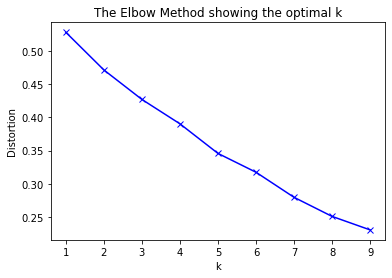

In [40]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(winnipeg_grouped_clustering)
    kmeanModel.fit(winnipeg_grouped_clustering)
    distortions.append(sum(np.min(cdist(winnipeg_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / winnipeg_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [41]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

winnipeg_merged = data

winnipeg_merged = winnipeg_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

winnipeg_merged.head()



,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Transcona,R2C,232143,49.88818,-96.99897,4.0,Train Station,Wine Shop,French Restaurant,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant
1,Transcona,R2C,384000,49.88818,-96.99897,4.0,Train Station,Wine Shop,French Restaurant,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant
2,Transcona,R2C,379900,49.88818,-96.99897,4.0,Train Station,Wine Shop,French Restaurant,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant
3,Transcona,R2C,264900,49.88818,-96.99897,4.0,Train Station,Wine Shop,French Restaurant,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant
4,Transcona,R2C,279900,49.88818,-96.99897,4.0,Train Station,Wine Shop,French Restaurant,Deli / Bodega,Department Store,Dim Sum Restaurant,Diner,Discount Store,Electronics Store,Falafel Restaurant


There was null value in the merged data so droping the rows with null values

In [42]:
winnipeg_merged.dropna(inplace=True)

Because of null values the data type of 'Cluster Labels' was changed from int to float so converting it back to int

In [43]:
winnipeg_merged['Cluster Labels'] = winnipeg_merged['Cluster Labels'].astype(int)
winnipeg_merged.dtypes

Neighborhood               object
PostCode                   object
AvePrice                    int64
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

#### There were many Location that were assigned the same postcodes as they were very near so droping the duplicate postcodes

In [44]:
winnipeg_merged.drop_duplicates(subset='PostCode',inplace=True)

In [45]:
winnipeg_merged.reset_index(inplace=True)
winnipeg_merged.drop(columns='index',inplace=True)

### Visualize the clusters

In [46]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(winnipeg_merged['Latitude'],winnipeg_merged['Longitude'], winnipeg_merged['Neighborhood'], winnipeg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Binning

### There is the range of Avg price so binned the price into 7 distinct values

### ('Low level 1', 'Low level 2', 'Average level 1', 'Average level 2','Above Average','High level 1','High level 2')
Visualizing the bins

Text(0.5, 1.0, 'Price bins')

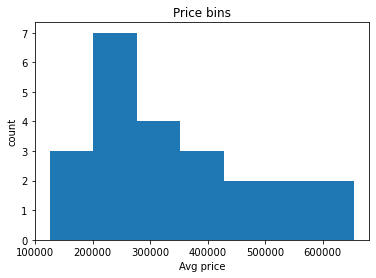

In [47]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(winnipeg_merged["AvePrice"],bins=7)

# set x/y labels and plot title
plt.pyplot.xlabel("Avg price")
plt.pyplot.ylabel("count")
plt.pyplot.title("Price bins")

In [48]:
bins = np.linspace(min(winnipeg_merged["AvePrice"]), max(winnipeg_merged["AvePrice"]), 8)
bins

array([125000., 200700., 276400., 352100., 427800., 503500., 579200.,
       654900.])

In [49]:
group_names = ['Low level 1', 'Low level 2', 'Average level 1', 'Average level 2','Above Average','High level 1','High level 2']

In [50]:
winnipeg_merged['Price-Categories'] = pd.cut(winnipeg_merged['AvePrice'], bins, labels=group_names, include_lowest=True )
winnipeg_merged[['AvePrice','Price-Categories']]

,AvePrice,Price-Categories
0,232143,Low level 2
1,184900,Low level 1
2,283873,Average level 1
3,249900,Low level 2
4,284900,Average level 1
5,364900,Average level 2
6,257606,Low level 2
7,499900,Above Average
8,125000,Low level 1
9,559900,High level 1


## Cluster bins

### Creating 4 bins for clusters

Text(0.5, 1.0, 'Cluster Labels')

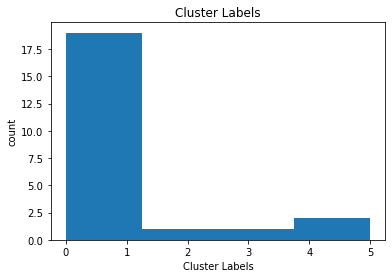

In [51]:
plt.pyplot.hist(winnipeg_merged["Cluster Labels"],bins=4)

# set x/y labels and plot title
plt.pyplot.xlabel("Cluster Labels")
plt.pyplot.ylabel("count")
plt.pyplot.title("Cluster Labels")

In [52]:
bins = np.linspace(min(winnipeg_merged["Cluster Labels"]), max(winnipeg_merged["Cluster Labels"]), 7)
bins

array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
       4.16666667, 5.        ])

In [53]:
group_names = ['Mixed Social Venues','Hotels and Social Venues','Stores and seafood restaurants','Pubs and Historic places', 'Sports and Athletics','Restaurants and Bars']

In [54]:
winnipeg_merged['Cluster-Category'] = pd.cut(winnipeg_merged['Cluster Labels'], bins, labels=group_names, include_lowest=True )
winnipeg_merged[['Cluster Labels','Cluster-Category']]

,Cluster Labels,Cluster-Category
0,4,Sports and Athletics
1,0,Mixed Social Venues
2,0,Mixed Social Venues
3,2,Stores and seafood restaurants
4,0,Mixed Social Venues
5,0,Mixed Social Venues
6,0,Mixed Social Venues
7,5,Restaurants and Bars
8,3,Pubs and Historic places
9,0,Mixed Social Venues


## Final Data

In [55]:
winnipeg_merged.drop(columns=['6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue'],inplace=True)
winnipeg_merged.head()

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
0,Transcona,R2C,232143,49.88818,-96.99897,4,Train Station,Wine Shop,French Restaurant,Deli / Bodega,Department Store,Low level 2,Sports and Athletics
1,River East North,R2G,184900,49.94218,-97.05900,0,Ice Cream Shop,Grocery Store,Juice Bar,Electronics Store,Chinese Restaurant,Low level 1,Mixed Social Venues
2,St. Boniface NW,R2H,283873,49.88606,-97.11885,0,Pharmacy,Discount Store,Grocery Store,Thrift / Vintage Store,Park,Average level 1,Mixed Social Venues
3,St. Boniface NE,R2J,249900,49.87144,-97.06417,2,Gym,Wine Shop,French Restaurant,Deli / Bodega,Department Store,Low level 2,Stores and seafood restaurants
4,River East Central,R2K,284900,49.92240,-97.08298,0,Gas Station,Business Service,Sporting Goods Shop,Massage Studio,Wine Shop,Average level 1,Mixed Social Venues


## Creating Chloropleth map to visualize how Winnipeg is divided in terms of Housing prices and cluster markers on the top

In [77]:
winn_geo = r'Neighbourhood.geojson'
winn_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

winn_map.choropleth(
    geo_data=winn_geo,
    data=winnipeg_merged,
    columns=['PostCode','AvePrice'],
    key_on='feature.properties.name',
    fill_color='OrRd', 
    fill_opacity=0.5, 
    line_opacity=0.2,
    legend_name='Average house Prices'
)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(winnipeg_merged['Latitude'],winnipeg_merged['Longitude'], winnipeg_merged['AvePrice'], winnipeg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='rainbow[cluster-1]',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(winn_map)
       
# display map
winn_map

### Examining the Clusters

### Cluster 1

In [58]:
winnipeg_merged[winnipeg_merged['Cluster Labels']==0]

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
1,River East North,R2G,184900,49.94218,-97.05900,0,Ice Cream Shop,Grocery Store,Juice Bar,Electronics Store,Chinese Restaurant,Low level 1,Mixed Social Venues
2,St. Boniface NW,R2H,283873,49.88606,-97.11885,0,Pharmacy,Discount Store,Grocery Store,Thrift / Vintage Store,Park,Average level 1,Mixed Social Venues
4,River East Central,R2K,284900,49.92240,-97.08298,0,Gas Station,Business Service,Sporting Goods Shop,Massage Studio,Wine Shop,Average level 1,Mixed Social Venues
5,River East South,R2L,364900,49.90680,-97.09913,0,Furniture / Home Store,Convenience Store,Baseball Field,Garden Center,French Restaurant,Average level 2,Mixed Social Venues
6,St. Vital North,R2M,257606,49.83875,-97.11591,0,Fast Food Restaurant,Pizza Place,Grocery Store,Bakery,Pub,Low level 2,Mixed Social Venues
9,Point Douglas West,R2X,559900,49.93353,-97.17103,0,Pharmacy,Bubble Tea Shop,Inn,Fast Food Restaurant,Convenience Store,High level 1,Mixed Social Venues
10,Broadway,R3C,569900,49.88447,-97.14871,0,Café,History Museum,Coffee Shop,Indian Restaurant,Sushi Restaurant,High level 1,Mixed Social Venues
11,Sargent Park,R3E,289900,49.91007,-97.17238,0,Chinese Restaurant,Fast Food Restaurant,Sandwich Place,Asian Restaurant,Noodle House,Average level 1,Mixed Social Venues
12,Minto,R3G,214595,49.88690,-97.18020,0,Wine Shop,Brewery,Ice Cream Shop,Lounge,Music Store,Low level 2,Mixed Social Venues
14,St. James-Assiniboia SW,R3K,409900,49.88058,-97.31582,0,Fast Food Restaurant,Restaurant,Paper / Office Supplies Store,Convenience Store,Coffee Shop,Average level 2,Mixed Social Venues


### Cluster 2

In [59]:
winnipeg_merged[winnipeg_merged['Cluster Labels']==1]

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
13,St. James-Assiniboia SE,R3J,231212,49.89617,-97.25348,1,Gym / Fitness Center,Gym,Bar,Wine Shop,French Restaurant,Low level 2,Hotels and Social Venues
20,Fort Garry West,R3Y,654900,49.79592,-97.20392,1,Pet Store,Park,Grocery Store,Coffee Shop,Fast Food Restaurant,High level 2,Hotels and Social Venues


### Cluster 3

In [182]:
winnipeg_merged[winnipeg_merged['Cluster Labels']==2]

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
1,Winnipeg (River East North),R2G,184900,49.94218,-97.05900,2,Ice Cream Shop,Grocery Store,Juice Bar,Electronics Store,Chinese Restaurant,Low level 1,Stores and seafood restaurants
4,Winnipeg (River East Central),R2K,284900,49.92240,-97.08298,2,Gas Station,Massage Studio,Business Service,Sporting Goods Shop,Wine Shop,Average level 1,Stores and seafood restaurants
5,Winnipeg (River East South),R2L,364900,49.90680,-97.09913,2,Furniture / Home Store,Convenience Store,Baseball Field,Garden Center,French Restaurant,Average level 2,Stores and seafood restaurants
6,Winnipeg (St. Vital North),R2M,257606,49.83875,-97.11591,2,Fast Food Restaurant,Pizza Place,Grocery Store,Bakery,Pub,Low level 2,Stores and seafood restaurants
9,Winnipeg (Point Douglas West / Inkster East),R2X,559900,49.93353,-97.17103,2,Pharmacy,Inn,Convenience Store,Pizza Place,Café,High level 1,Stores and seafood restaurants
10,Winnipeg (Broadway / The Forks / Portage and M...,R3C,569900,49.88447,-97.14871,2,Café,Monument / Landmark,History Museum,Outdoors & Recreation,Indian Restaurant,High level 1,Stores and seafood restaurants
11,Winnipeg (Sargent Park / Daniel McIntyre / Ink...,R3E,289900,49.91007,-97.17238,2,Chinese Restaurant,Sandwich Place,Fast Food Restaurant,Vietnamese Restaurant,Noodle House,Average level 1,Stores and seafood restaurants
12,Winnipeg (Minto / St. Mathews / Wolseley),R3G,214595,49.88690,-97.18020,2,Wine Shop,Bike Shop,Convenience Store,Music Store,Coffee Shop,Low level 2,Stores and seafood restaurants
13,Winnipeg (St. James-Assiniboia SE),R3J,231212,49.89617,-97.25348,2,Gym / Fitness Center,Gym,Bar,Stables,Wine Shop,Low level 2,Stores and seafood restaurants
14,Winnipeg (St. James-Assiniboia SW),R3K,409900,49.88058,-97.31582,2,Fast Food Restaurant,Restaurant,Hotel,Bus Station,Grocery Store,Average level 2,Stores and seafood restaurants


### Cluster 4

In [183]:
winnipeg_merged[winnipeg_merged['Cluster Labels']==3]

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
2,Winnipeg (St. Boniface NW),R2H,283873,49.88606,-97.11885,3,Pharmacy,Park,Café,Grocery Store,Gas Station,Average level 1,Pubs and Historic places
20,Winnipeg (Fort Garry West),R3Y,654900,49.79592,-97.20392,3,Pet Store,Park,Grocery Store,Coffee Shop,Fast Food Restaurant,High level 2,Pubs and Historic places
22,Winnipeg (River Heights West),R3N,428226,49.86316,-97.19607,3,Pizza Place,Italian Restaurant,Convenience Store,Café,Sandwich Place,Above Average,Pubs and Historic places


### Cluster 5

In [184]:
winnipeg_merged[winnipeg_merged['Cluster Labels']==4]

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
3,Winnipeg (St. Boniface NE),R2J,249900,49.87144,-97.06417,4,Gym,Wine Shop,French Restaurant,Department Store,Dim Sum Restaurant,Low level 2,Sports and Athletics


### Cluster 6

In [185]:
winnipeg_merged[winnipeg_merged['Cluster Labels']==5]

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
0,Winnipeg (Transcona),R2C,232143,49.88818,-96.99897,5,Train Station,Wine Shop,French Restaurant,Department Store,Dim Sum Restaurant,Low level 2,Restaurants and Bars


## Examining Property prices

In [186]:
winnipeg_merged[winnipeg_merged['Price-Categories']=='High level 2']

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
17,Winnipeg (Fort Garry NW / Tuxedo),R3P,579900,49.84530,-97.20563,2,Dance Studio,Golf Course,Sporting Goods Shop,Shoe Store,Fast Food Restaurant,High level 2,Stores and seafood restaurants
20,Winnipeg (Fort Garry West),R3Y,654900,49.79592,-97.20392,3,Pet Store,Park,Grocery Store,Coffee Shop,Fast Food Restaurant,High level 2,Pubs and Historic places


In [187]:
winnipeg_merged[winnipeg_merged['Price-Categories']=='High level 1']

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
9,Winnipeg (Point Douglas West / Inkster East),R2X,559900,49.93353,-97.17103,2,Pharmacy,Inn,Convenience Store,Pizza Place,Café,High level 1,Stores and seafood restaurants
10,Winnipeg (Broadway / The Forks / Portage and M...,R3C,569900,49.88447,-97.14871,2,Café,Monument / Landmark,History Museum,Outdoors & Recreation,Indian Restaurant,High level 1,Stores and seafood restaurants


In [188]:
winnipeg_merged[winnipeg_merged['Price-Categories']=='Low level 2']

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
0,Winnipeg (Transcona),R2C,232143,49.88818,-96.99897,5,Train Station,Wine Shop,French Restaurant,Department Store,Dim Sum Restaurant,Low level 2,Restaurants and Bars
3,Winnipeg (St. Boniface NE),R2J,249900,49.87144,-97.06417,4,Gym,Wine Shop,French Restaurant,Department Store,Dim Sum Restaurant,Low level 2,Sports and Athletics
6,Winnipeg (St. Vital North),R2M,257606,49.83875,-97.11591,2,Fast Food Restaurant,Pizza Place,Grocery Store,Bakery,Pub,Low level 2,Stores and seafood restaurants
12,Winnipeg (Minto / St. Mathews / Wolseley),R3G,214595,49.88690,-97.18020,2,Wine Shop,Bike Shop,Convenience Store,Music Store,Coffee Shop,Low level 2,Stores and seafood restaurants
13,Winnipeg (St. James-Assiniboia SE),R3J,231212,49.89617,-97.25348,2,Gym / Fitness Center,Gym,Bar,Stables,Wine Shop,Low level 2,Stores and seafood restaurants
15,Winnipeg (River Heights East),R3L,271628,49.86946,-97.12289,2,Playground,Harbor / Marina,Food Truck,Deli / Bodega,Department Store,Low level 2,Stores and seafood restaurants
16,Winnipeg (River Heights Central),R3M,271628,49.86273,-97.16449,2,Pharmacy,Middle Eastern Restaurant,Thai Restaurant,Bank,Deli / Bodega,Low level 2,Stores and seafood restaurants


In [189]:
winnipeg_merged[winnipeg_merged['Price-Categories']=='Low level 1']

,Neighborhood,PostCode,AvePrice,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Price-Categories,Cluster-Category
1,Winnipeg (River East North),R2G,184900,49.94218,-97.05900,2,Ice Cream Shop,Grocery Store,Juice Bar,Electronics Store,Chinese Restaurant,Low level 1,Stores and seafood restaurants
8,Winnipeg (Point Douglas East),R2W,125000,49.91905,-97.14046,1,Deli / Bodega,Fast Food Restaurant,French Restaurant,Department Store,Dim Sum Restaurant,Low level 1,Hotels and Social Venues
21,Winnipeg (Chinatown / Civic Centre / Exchange ...,R3B,139900,49.89919,-97.13432,2,Coffee Shop,Hotel,Bakery,Nightclub,Café,Low level 1,Stores and seafood restaurants
